In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

    
def plot_samples_on_epoch(samples, nrow=4, chanels=3, size=(8,8)):
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow)
    if chanels==1:
        see_plot(grid_img.permute(1, 2, 0)*255, size=size)
    else:
        see_plot(grid_img.permute(1, 2, 0), size=size)
        
def see_plot(pict, size=(6,6)):
    plt.figure(figsize=size)
    plt.imshow(pict,cmap='gray') #, cmap=color, color='gray'
    plt.grid()
    plt.show()

def load_image(video, frame):
    path = '/media/laggg/surviv_rl_data/all_videoframes_rgb_96/{}/'.format(video)
    p = cv2.imread(path + 'f_{}.jpg'.format(frame))
    return p[:,:,::-1]
#----------------------------------------------------------------------------------------------------
        
# info
print('torch_version: {},\ntorchvision_version: {}'.format(torch.__version__,torchvision.__version__))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

torch_version: 1.8.1+cu102,
torchvision_version: 0.8.1
device: cuda:0


In [2]:
#-----------------------------------------------------------------------------------------
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

def plot_confusion_matrix(targets,predictions,classes,
                          normalize=True,title='Confusion matrix',
                          figsize=(4, 4), cmap=plt.cm.Reds):

    conf_matrix = confusion_matrix(y_true=targets, y_pred=predictions)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title.lower()

    plt.figure(figsize=figsize)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):

        if normalize:
            value = '{} %'.format(format(conf_matrix[i, j] * 100, '.2f'))
        else:
            value = format(conf_matrix[i, j], fmt)

        plt.text(j,i,value,horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
    plt.show()

## Data

In [3]:
# Val df:
val_p = []
val_t = []
path = './final_dataset_stone/val/stone/'
for x in os.listdir(path):
    val_p.append(path+x)
    val_t.append(1)
path = './final_dataset_stone/val/nostone/'
for x in os.listdir(path):
    val_p.append(path+x)
    val_t.append(0)
    
df_val = pd.DataFrame({'img_path': val_p, 'target': val_t})
print(df_val.shape, np.unique(df_val.target, return_counts=True))
df_val.sample(5)

(598, 2) (array([0, 1]), array([405, 193]))


,img_path,target
452,./final_dataset_stone/val/nostone/137665_5_3_5...,0
519,./final_dataset_stone/val/nostone/137503_2_2_1...,0
305,./final_dataset_stone/val/nostone/135073_1_1_1...,0
419,./final_dataset_stone/val/nostone/128560_1_2.png,0
515,./final_dataset_stone/val/nostone/201544_5_2.png,0


In [4]:
# Val df:
train_p = []
train_t = []
path = './final_dataset_stone/train/stone/'
for x in os.listdir(path):
    train_p.append(path+x)
    train_t.append(1)
path = './final_dataset_stone/train/nostone/'
for x in os.listdir(path):
    train_p.append(path+x)
    train_t.append(0)
    
df_train = pd.DataFrame({'img_path': train_p, 'target': train_t})
print(df_train.shape, np.unique(df_train.target, return_counts=True))
df_train.sample(5)

(5254, 2) (array([0, 1]), array([4139, 1115]))


,img_path,target
1838,./final_dataset_stone/train/nostone/95326_4_2_...,0
3130,./final_dataset_stone/train/nostone/101537_7_4...,0
1108,./final_dataset_stone/train/stone/26829_7_5_2_...,1
667,./final_dataset_stone/train/stone/108240_3_1.png,1
2278,./final_dataset_stone/train/nostone/122910_1_2...,0


## DataLoader

In [5]:
def apply_aug(p0, aug):
    if aug == 0:
        p = p0.copy()
    elif aug == 1:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
    elif aug == 2:
        p = cv2.rotate(p0, cv2.ROTATE_180)
    elif aug == 3:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif aug == 4:
        p = cv2.flip(p0, 1)
    elif aug == 5:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
        p = cv2.flip(p, 1)
    elif aug == 6:
        p = cv2.rotate(p0, cv2.ROTATE_180)
        p = cv2.flip(p, 1)
    elif aug == 7:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
        p = cv2.flip(p, 1)
    return p


class Stone_Dataset(Dataset):
    def __init__(self, df, augs=None):
        super().__init__()
        self.df = df
        self.augs = augs
        self.transform =  A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                                     ToTensorV2(transpose_mask=False)])
  
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.df[idx][0])[:,:,::-1]
        target = self.df[idx][1]
        #target = F.one_hot(torch.tensor(self.df[idx][1]), num_classes=2).float()
        if self.augs:
            aug = np.random.choice(np.arange(8), p=np.array([0.125]*8))
            img = apply_aug(img, aug)
        img = self.transform(image=img)['image']
        return img, target

## Model

In [6]:
class StoneClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 2, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 2, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 2, 1)
        self.fc1 = nn.Linear(32 * 3 * 3, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

## Train

In [7]:
def train_model(model, train_iterator, val_iterator, loss_func, optimizer, sheduler, params):
    best_metr = 0
    reward_frame_transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(24)])
    
    for i in range(params['EPOCHS']):
        #===========TRAIN=============================
        time.sleep(0.2)
        model.train(True)
        train_loss = 0.0
        y_pred = []
        y_true = []
        for x in enumerate(train_iterator): #tqdm(train_iterator)
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            img = reward_frame_transform(img)
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            y_pred.extend((output[:,1]>0.95).int().detach().cpu().tolist())
            y_true.extend(target.detach().cpu().tolist())
        f1_macro = round(f1_score(y_true, y_pred, average='macro'),4)
        train_loss = round(train_loss / len(train_iterator),4)
        trainloss_ts.append(train_loss)
        trainmetr_ts.append(f1_macro)
        current_lr = optimizer.param_groups[0]['lr']
        sheduler.step()

        #===========VAL================================
        time.sleep(0.2)
        model.train(False)
        val_loss = 0.0
        y_pred = []
        y_true = []
        for x in enumerate(val_iterator):
            img = x[1][0].to(params['DEVICE'])
            target = x[1][1].to(params['DEVICE'])
            img = reward_frame_transform(img)
            with torch.no_grad():
                output = model(img)
            loss = loss_func(output, target)
            val_loss += loss.item()
            y_pred.extend((output[:,1]>0.95).int().detach().cpu().tolist())
            y_true.extend(target.detach().cpu().tolist())
        f1_macro = round(f1_score(y_true, y_pred, average='macro'),4)
        val_loss = round(val_loss / len(val_iterator),4)
        valloss_ts.append(val_loss)
        valmetr_ts.append(f1_macro)
        if f1_macro>best_metr:
            best_metr = f1_macro
            torch.save(model.state_dict(), 'laggg_stone_classifier_v1.pth')
            
        #==========PRINT===========================
        print(f'{i+1}/{params["EPOCHS"]}',
              'lr:',current_lr,'|',
              'train_loss:',trainloss_ts[-1],'|',
              'val_loss:',valloss_ts[-1],'|',
              'train_metr:',trainmetr_ts[-1],'|',
              'val_metr:',valmetr_ts[-1])

tensor([0, 0, 1, 0, 0, 0, 1, 0])


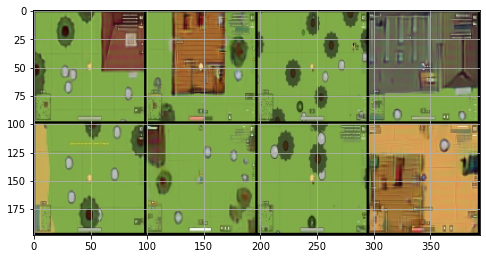

In [8]:
params = {'EPOCHS': 30,
          'DEVICE': 'cuda:0',
          'BATCH': 8}

train_data = Stone_Dataset(df_train.values, True)
train_dataloader = DataLoader(train_data, batch_size=params['BATCH'], shuffle=True)
test_data = Stone_Dataset(df_val.values, False)
test_dataloader = DataLoader(test_data, batch_size=params['BATCH'], shuffle=True)

img, target = iter(test_dataloader).next()
print(target)
plot_samples_on_epoch((img+1)/2)

In [9]:
model = StoneClassifier().to(params['DEVICE'])

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)

trainloss_ts = []
trainmetr_ts = []
valloss_ts = []
valmetr_ts = []
train_model(model, train_dataloader, test_dataloader,
            criterion, opt, scheduler, params)

1/30 lr: 0.001 | train_loss: 0.528 | val_loss: 0.6366 | train_metr: 0.4406 | val_metr: 0.4038
2/30 lr: 0.001 | train_loss: 0.5237 | val_loss: 0.5989 | train_metr: 0.4406 | val_metr: 0.4038
3/30 lr: 0.001 | train_loss: 0.495 | val_loss: 0.4833 | train_metr: 0.4763 | val_metr: 0.6069
4/30 lr: 0.001 | train_loss: 0.445 | val_loss: 0.4556 | train_metr: 0.717 | val_metr: 0.8068
5/30 lr: 0.001 | train_loss: 0.434 | val_loss: 0.4473 | train_metr: 0.763 | val_metr: 0.8211
6/30 lr: 0.001 | train_loss: 0.4319 | val_loss: 0.4543 | train_metr: 0.7789 | val_metr: 0.7831
7/30 lr: 0.001 | train_loss: 0.4277 | val_loss: 0.4552 | train_metr: 0.785 | val_metr: 0.8022
8/30 lr: 0.001 | train_loss: 0.4241 | val_loss: 0.4514 | train_metr: 0.7983 | val_metr: 0.8031
9/30 lr: 0.001 | train_loss: 0.4238 | val_loss: 0.4541 | train_metr: 0.7858 | val_metr: 0.8233
10/30 lr: 0.001 | train_loss: 0.4202 | val_loss: 0.4545 | train_metr: 0.7949 | val_metr: 0.8348
11/30 lr: 0.0001 | train_loss: 0.4177 | val_loss: 0.4417

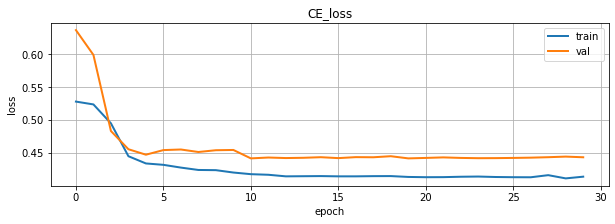

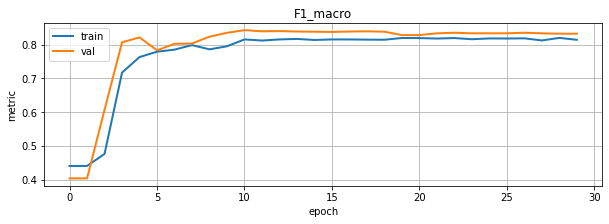

In [10]:
plt.figure(figsize=(10,3));
plt.plot(trainloss_ts, label='train', linewidth=2)
plt.plot(valloss_ts, label='val', linewidth=2)
plt.title('CE_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show();

plt.figure(figsize=(10,3));
plt.plot(trainmetr_ts, label='train', linewidth=2)
plt.plot(valmetr_ts, label='val', linewidth=2)
plt.title('F1_macro')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show();

## Validate

In [11]:
params = {'EPOCHS': 30,
          'DEVICE': 'cuda:0',
          'BATCH': 8}

def validate(model, tresh=0.5, confm_normalize=True):
    y_pred = []
    y_true = []
    model.eval()
    reward_frame_transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(24)])
    for x in enumerate(test_dataloader):
        img = x[1][0].to(params['DEVICE'])
        target = x[1][1]
        y_true.extend(target.tolist())
        img = reward_frame_transform(img)
        with torch.no_grad():
            r = model(img)[:,1]
        r = (r>tresh).int().detach().cpu().tolist()
        y_pred.extend(r)
    val_acc = round(accuracy_score(y_true, y_pred),4)
    val_f1 = round(f1_score(y_true, y_pred, average='macro'),4)
    print('f1 macro:', val_f1)
    plot_confusion_matrix(y_true, y_pred, range(2), normalize=confm_normalize)

In [12]:
model1 = StoneClassifier()
model1.load_state_dict(torch.load('../../rl_approaches/model_weights/nostone_stone_classifier.pth'))
model1 = model1.to(params['DEVICE'])

model2 = StoneClassifier()
model2.load_state_dict(torch.load('dfomin_stone_classifier_v2.pth'))
model2 = model2.to(params['DEVICE'])

model3 = StoneClassifier()
model3.load_state_dict(torch.load('laggg_stone_classifier_v1.pth'))
model3 = model3.to(params['DEVICE'])

f1 macro: 0.8356


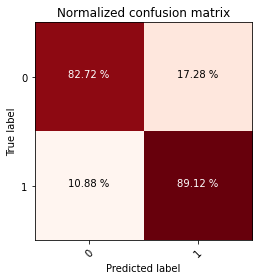

f1 macro: 0.8442


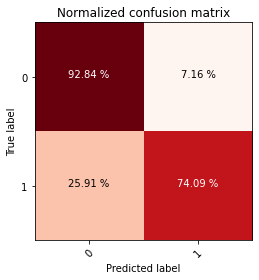

f1 macro: 0.8427


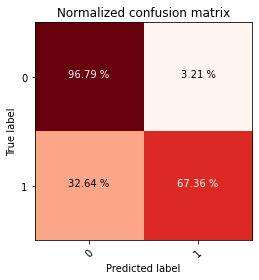

In [13]:
validate(model1, tresh=0.95)
validate(model2, tresh=0.95)
validate(model3, tresh=0.95)